In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import generic_protein
import re

In [2]:
# read in neut data

neut_file_path = '../data/PG9_IC50_IC80.txt'

neuts = pd.read_table(neut_file_path, header=0)
neuts.rename(columns={'Virus name':'name', 
              'Subtype':'subtype',
              'PG9: IC50 geometric mean':'IC50',
              'PG9: IC80 geometric mean':'IC80'}, inplace=True)
# neuts.set_index('name', inplace=True)
neuts.drop(['Tier', 'Country', 'Accession', 'Alias', 'Seq data', 
            ' PG9: IC50 by study', ' PG9: IC80 by study', 'Unnamed: 11'], 
            axis=1, inplace=True)
neuts = neuts[neuts.name != 'Geometric mean of detected']
neuts = neuts[neuts.name != 'Geometric mean of all(undetected set to 100)'] 
neuts = neuts[neuts.name != '% detected (detected/total)'] 

In [3]:
# read in sequence data

virus_name = []
virus_seq = []
passed_seqs = []

fasta_file_path = '../data/PG9 virus aa align.fasta'

for seq_record in SeqIO.parse(fasta_file_path, 'fasta', 
                              alphabet=generic_protein):
    try:
        virus_name.append(seq_record.id.split('.')[2])
        virus_seq.append(seq_record.seq)
    except:
        passed_seqs.append(seq_record)

HXB2 = passed_seqs[0]

In [4]:
# convert sequence data to DataFrame

seq_dict = {'sequence' : pd.Series(virus_seq, index=virus_name, 
                                   dtype='object')}
seq_df = pd.DataFrame(seq_dict)

In [5]:
# merge neuts and seq_df

neutdf = pd.merge(neuts, seq_df, how='inner', left_on='name', 
                    right_index=True)

In [6]:
# define neut categories

def binarize_IC50(row):
    if '>' in row.IC50:
        return 0
    else:
        value = float(row.IC50)
        return 0 if value > 50 else 1

neutdf['is_neutralized'] = neutdf.apply(binarize_IC50, axis=1)


In [7]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized
0,0013095_2_11,C,0.01889,0.06536,"(M, R, V, K, G, -, I, L, R, N, Y, Q, Q, W, W, ...",1
1,001428_2_42,C,0.01105,0.01686,"(M, R, V, R, G, -, I, L, R, N, Y, Q, Q, W, W, ...",1
2,0077_V1_C16,C,0.08934,0.34275,"(M, R, V, M, G, -, S, M, R, N, C, Q, R, W, W, ...",1
3,00836_2_5,C,49.00000,UD:>50,"(M, R, V, R, G, -, I, R, R, N, Y, Q, H, W, W, ...",1
4,0260_V5_C36,A1,1.98621,17.35454,"(M, R, V, M, G, -, I, Q, R, N, S, Q, C, F, L, ...",1


# Feature Extraction

    Tokenize sequences w/ position value and amino acid identity
    Tokenize PNGS sites with a regex
    Vectorize tokens and create dataframe of dummy variables
    

In [8]:
# define function to tokenize sequence
# input = sequence object, output = dictionary where index is position and
# token is amino acid identity at that position

amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def sequence_tokenizer(seq):
    """
    
    """
    seq_list = list(str(seq).strip('*'))
    working_peptide = list(enumerate(seq_list, start=1))
    peptide_dict = {}
    for index, amino in working_peptide:
        if amino in amino_acids:
            peptide_dict.update({index : amino})
        else: 
            pass
    return peptide_dict


In [9]:
# define function to tokenize potential N-linked glycosylation sites 
# (PNGS) in sequence
# input = sequence object, output = dictionary where index is position
# and token = 'PNGS'

def PNGS_tokenizer(seq):
    seq_string = str(seq).strip('*')
    PNGS_dict = {m.start(0)+1 : 'PNGS' 
                for m in re.finditer(r"N[^P][ST]", seq_string)}
    return PNGS_dict


In [10]:
# define feature extraction function where input = seq object and 
# output = one dictionary of all features

def get_features(seq, use_positions=True, use_PNGS=True):
    features = {}
    if use_positions:
        sequence_features = sequence_tokenizer(seq)
        features.update(sequence_features)
    if use_PNGS:
        PNGS_features = PNGS_tokenizer(seq)
        features.update(PNGS_features)
    return features


In [11]:
# map get_features function to sequence column of neutdf

neutdf['features_dict'] = neutdf.sequence.map(get_features)


In [12]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized,features_dict
0,0013095_2_11,C,0.01889,0.06536,"(M, R, V, K, G, -, I, L, R, N, Y, Q, Q, W, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'K', 5: u'G', ..."
1,001428_2_42,C,0.01105,0.01686,"(M, R, V, R, G, -, I, L, R, N, Y, Q, Q, W, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
2,0077_V1_C16,C,0.08934,0.34275,"(M, R, V, M, G, -, S, M, R, N, C, Q, R, W, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."
3,00836_2_5,C,49.00000,UD:>50,"(M, R, V, R, G, -, I, R, R, N, Y, Q, H, W, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
4,0260_V5_C36,A1,1.98621,17.35454,"(M, R, V, M, G, -, I, Q, R, N, S, Q, C, F, L, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."


In [13]:
# vectorize data and build feature df

from sklearn.feature_extraction import DictVectorizer

d_vect = DictVectorizer()

list_features = list(neutdf.features_dict)
sparse_features = d_vect.fit_transform(list_features)
name_features = d_vect.get_feature_names()

features_df = pd.DataFrame(sparse_features.toarray(), columns=name_features)

features_df.head()

,100=I,100=K,100=L,100=M,100=Q,100=R,100=V,100=Y,101=A,101=D,...,992=Q,992=V,993=Q,99=E,9=K,9=M,9=N,9=R,9=S,9=T
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [73]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[169]

207

In [15]:
# Examine features at positions 665 & 667 (MSA: 789 & 791)

epitope_features = [col for col in features_df.columns if '197' in col]
print epitope_features

['197=D', '197=H', '197=K', '197=N', '197=PNGS', '197=R', '197=S', '197=T', '197=Y']


# Feature Selection

    Trim down feature outliers (highly conserved sequences & single variants)
    Other feature selection approaches (mRMR, incorporated methods)

In [35]:
feature_counts = np.sum(features_df, axis=0)/features_df.shape[0]

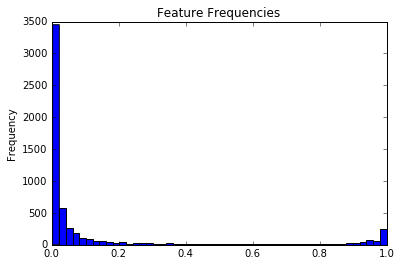

In [44]:
import matplotlib as plt
% matplotlib inline

feature_counts.plot.hist(title='Feature Frequencies', bins=50)

In [45]:
# define function to drop features that are shared by less than X% of sequences and/or more
# than 1-X% of sequences

def trim_feature_extremes(dataframe, percent_to_trim):
    total_rows = dataframe.shape[0]
    upper_threshold = (1 - percent_to_trim) * total_rows
    lower_threshold = percent_to_trim * total_rows
    column_filter_list = list((dataframe.sum(axis=0) >= lower_threshold) &
                                (dataframe.sum(axis=0) < upper_threshold)) 
                                #True = keep, False = drop
    column_filter_dict = zip(list(dataframe.columns), column_filter_list)
    columns_to_keep = [column for column, keepornot in column_filter_dict 
                        if keepornot == True]
    output_df = dataframe[columns_to_keep]
    return output_df
 

In [47]:
trimmed_features_df = trim_feature_extremes(features_df, 0.05)

trimmed_features_df.shape

(365, 1368)

# Build Decision Tree Classifier

    Use for feature selection


In [18]:
# define X & y as whole feature set without trimming features

X = features_df
y = neutdf.is_neutralized


In [19]:
# calculate best depth using roc_auc score

from sklearn.tree import DecisionTreeClassifier

max_depth_range = range(1, 101)

roc_auc_scores = []

from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(treeclass, X, y, scoring='roc_auc', cv=10)
    roc_auc_scores.append(np.mean(score))
    
print roc_auc_scores

[0.6611111111111112, 0.62633744855967088, 0.64351851851851849, 0.66679012345679012, 0.67191358024691361, 0.65969135802469137, 0.65502057613168729, 0.64129629629629625, 0.68067901234567896, 0.66458847736625515, 0.67401234567901225, 0.6581687242798353, 0.67631687242798366, 0.68360082304526748, 0.67170781893004128, 0.662201646090535, 0.66121399176954732, 0.67855967078189283, 0.68685185185185182, 0.67174897119341559, 0.67979423868312749, 0.6770370370370371, 0.68944444444444453, 0.68055555555555558, 0.69240740740740736, 0.68629629629629629, 0.64796296296296296, 0.66148148148148156, 0.68259259259259264, 0.66462962962962968, 0.68370370370370359, 0.70481481481481478, 0.66888888888888898, 0.66888888888888887, 0.67574074074074086, 0.69870370370370372, 0.682037037037037, 0.68018518518518523, 0.67574074074074075, 0.68629629629629629, 0.66648148148148156, 0.66648148148148145, 0.69555555555555548, 0.6962962962962963, 0.68574074074074065, 0.67074074074074075, 0.69685185185185183, 0.64740740740740743,

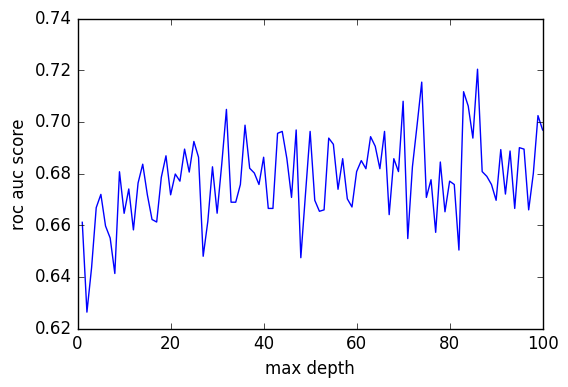

In [20]:
# graph roc_auc_scores vs max depth

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(max_depth_range, roc_auc_scores)
plt.xlabel('max depth')
plt.ylabel('roc auc score')

plt.rcdefaults()

In [21]:
sorted(zip(roc_auc_scores, max_depth_range), reverse=True)[0]

(0.72037037037037044, 86)

In [22]:
# fit tree using max depth of 3

treeclass = DecisionTreeClassifier(max_depth=80)
treeclass.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=80,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [30]:
# get feature importances

feat_import = pd.DataFrame({'feature': features_df.columns, 'importance': treeclass.feature_importances_})
feat_import.sort_values('importance', ascending=False).head(10)

,feature,importance
919,197=PNGS,0.235626
256,149=E,0.064417
3119,498=PNGS,0.056379
4986,844=F,0.053418
3940,604=K,0.042245
4394,729=A,0.037772
4192,664=R,0.035379
4861,810=R,0.029485
5819,979=I,0.028358
997,207=E,0.025324


In [26]:
# look at other feature importances at same sites

features_197 = [feat for feat in feat_import.feature if '197' in feat]
features_207 = [feat for feat in feat_import.feature if '207' in feat]

In [27]:
feat_import.set_index('feature', inplace=True)
import_feat = feat_import.transpose()
import_feat[features_197]

feature,197=D,197=H,197=K,197=N,197=PNGS,197=R,197=S,197=T,197=Y
importance,0,0,0,0,0.235626,0,0,0,0


In [29]:
import_feat[features_207]

feature,207=E,207=G,207=H,207=I,207=K,207=L,207=M,207=N,207=P,207=Q,207=R,207=S,207=T,207=V,207=W,207=Y
importance,0.025324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Build Random Forest
    
    Use randomized grid search CV for n_estimators, max_features

In [54]:
# import random forest classifier & define X & y using trimmed dataframe

from sklearn.ensemble import RandomForestClassifier

rfclass = RandomForestClassifier()

X = trimmed_features_df
y = neutdf.is_neutralized

In [55]:
from sklearn.grid_search import RandomizedSearchCV

estimators_range = range(0, 1501, 10)
feature_range = range(0, 501)

In [57]:
param_dist = dict(n_estimators=estimators_range, max_features=feature_range)
rand = RandomizedSearchCV(rfclass, param_dist, n_iter=50, scoring='roc_auc', cv=5)
rand.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, ...40, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='roc_auc', verbose=0)

In [60]:
grid = pd.DataFrame(rand.grid_scores_).sort_values('mean_validation_score', ascending=False)
grid.head(50)

,parameters,mean_validation_score,cv_validation_scores
27,"{u'n_estimators': 1100, u'max_features': 363}",0.797856,"[0.711013645224, 0.780701754386, 0.75292397660..."
34,"{u'n_estimators': 960, u'max_features': 387}",0.796199,"[0.712962962963, 0.767543859649, 0.74853801169..."
32,"{u'n_estimators': 1260, u'max_features': 373}",0.796199,"[0.704191033138, 0.774366471735, 0.75389863547..."
1,"{u'n_estimators': 1440, u'max_features': 347}",0.792885,"[0.710526315789, 0.763645224172, 0.75682261208..."
14,"{u'n_estimators': 1000, u'max_features': 357}",0.792008,"[0.702729044834, 0.769493177388, 0.74707602339..."
6,"{u'n_estimators': 530, u'max_features': 364}",0.791910,"[0.707602339181, 0.769493177388, 0.74561403508..."
35,"{u'n_estimators': 650, u'max_features': 399}",0.791813,"[0.7022417154, 0.762670565302, 0.744639376218,..."
17,"{u'n_estimators': 1010, u'max_features': 388}",0.791326,"[0.691520467836, 0.760233918129, 0.74317738791..."
39,"{u'n_estimators': 950, u'max_features': 493}",0.791228,"[0.701754385965, 0.748538011696, 0.75925925925..."
10,"{u'n_estimators': 540, u'max_features': 426}",0.791033,"[0.706140350877, 0.75, 0.759746588694, 0.87670..."


In [61]:
# look at best parameters

print rand.best_score_
print rand.best_params_

0.797855750487
{'n_estimators': 1100, 'max_features': 363}


In [62]:
# fit random forest with best parameters

rfclass = RandomForestClassifier(n_estimators=1000, max_features=350, oob_score=True)
rfclass.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=350, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [63]:
# look at feature importances

forest_features_import = pd.DataFrame({'feature': X.columns, 'importance': rfclass.feature_importances_})
forest_features_import.sort_values('importance', ascending=False).head(10)

,feature,importance
194,197=PNGS,0.139429
199,198=V,0.009887
1233,918=S,0.009719
572,439=K,0.009535
446,380=Q,0.009317
1231,917=R,0.009141
463,390=Q,0.008771
1237,921=G,0.008544
1238,922=L,0.008049
1108,844=F,0.007875


In [64]:
# oob score

rfclass.oob_score_

0.83561643835616439

# Fit Logistic Regression with best features

    Evaluate with different iterations of selected features
    

In [65]:
# define new df with selected features & perform train/test split

selected_features = ['197=PNGS', '198=V', '918=S', '439=K', '380=Q', '917=R']
X = features_df[selected_features]
y = neutdf.is_neutralized

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)

In [66]:
# fit logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
# look at coefficients

print logreg.coef_

[[ 3.99916218 -0.87146928  0.98080075 -1.50670336 -0.19912437 -1.71105092]]


In [68]:
# evaluate log loss

from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)
print metrics.log_loss(y_test, y_pred_proba)

0.406672812828


In [69]:
# evaluate MCC

y_pred_class = logreg.predict(X_test)
print metrics.matthews_corrcoef(y_test, y_pred_class)

0.520362530222


In [70]:
# do above with different feature combinations

feature_selections = [['197=PNGS', '198=V', '918=S', '439=K', '380=Q', '917=R'], 
                      ['197=PNGS', '198=V', '918=S', '439=K', '380=Q'], ['197=PNGS', '198=V', '918=S', '439=K'], 
                      ['197=PNGS', '198=V', '918=S'], ['197=PNGS', '198=V'], ['197=PNGS']]

log_loss_scores = []
MCC_scores = []

for selection in feature_selections:
    X = features_df[selection]
    y = neutdf.is_neutralized
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, y_pred_proba)
    y_pred_class = logreg.predict(X_test)
    MCC = metrics.matthews_corrcoef(y_test, y_pred_class)
    log_loss_scores.append(log_loss)
    MCC_scores.append(MCC)

In [72]:
# make a dataframe of the above

log_reg_eval = pd.DataFrame({'features': feature_selections, 'log loss': log_loss_scores, 'MCC': MCC_scores})
log_reg_eval.sort_values('MCC', ascending=False)

,MCC,features,log loss
2,0.630985,"[197=PNGS, 198=V, 918=S, 439=K]",0.369589
1,0.573858,"[197=PNGS, 198=V, 918=S, 439=K, 380=Q]",0.434469
5,0.528498,[197=PNGS],0.453648
0,0.460378,"[197=PNGS, 198=V, 918=S, 439=K, 380=Q, 917=R]",0.510261
3,0.381582,"[197=PNGS, 198=V, 918=S]",0.449387
4,0.313184,"[197=PNGS, 198=V]",0.721020
